# CC_NEWS

O dataset CC_NEWS contém notícias de sites de notícia de qualquer lugar do mundo.

Ele contém 708.241 notícias em inglês, publicadas entre Janeiro de 2017 e Dezembro de 2019.

Colunas:
- date: Data da publicação
- description: Descrição ou resumo da notícia
- domain: domínio de origem
- image_url: URL da imagem da notícia
- text: Texto do da notícia
- title: Título da notícia
- url: URL da notícia

In [88]:
from datasets import load_dataset

import spacy

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

from tqdm import tqdm
from collections import Counter
import numpy as np
import pandas as pd
import random

nlp = spacy.load("en_core_web_sm", enable=["tokenizer"])

In [3]:
ds = load_dataset("vblagoje/cc_news")

In [4]:
ds['train']

Dataset({
    features: ['title', 'text', 'domain', 'date', 'description', 'url', 'image_url'],
    num_rows: 708241
})

In [5]:
ds_small = ds['train'].select(range(10000)).select_columns(['title', 'text', 'domain'])
ds_small

Dataset({
    features: ['title', 'text', 'domain'],
    num_rows: 10000
})

In [6]:
print("Quantidade de domínios:", len(ds_small.unique('domain')))
ds_small.unique('domain')[:10]

Quantidade de domínios: 88


['www.pointemagazine.com',
 'www.designwizard.com',
 'baycommunitynews.com',
 'www.techrepublic.com',
 'banglalive.com',
 'www.fitzhugh.ca',
 'www.grandforksherald.com',
 'onefoottsunami.com',
 'tpr.org',
 'www.sparkspread.com']

In [98]:
counter = {domain: 0 for domain in ds_small['domain']}

for domain in ds_small['domain']:
    counter[domain] += 1

ds_explore = pd.DataFrame.from_dict(counter,orient='index', columns=['count'])
ds_explore.sort_values('count', ascending=False)

,count
www.taiwannews.com.tw,3103
abcnews.go.com,2110
www.israelnationalnews.com,761
newyork.cbslocal.com,481
abc7news.com,393
...,...
n.rivals.com,1
info.umkc.edu,1
www.citizen-times.com,1
www.designwizard.com,1


<Axes: >

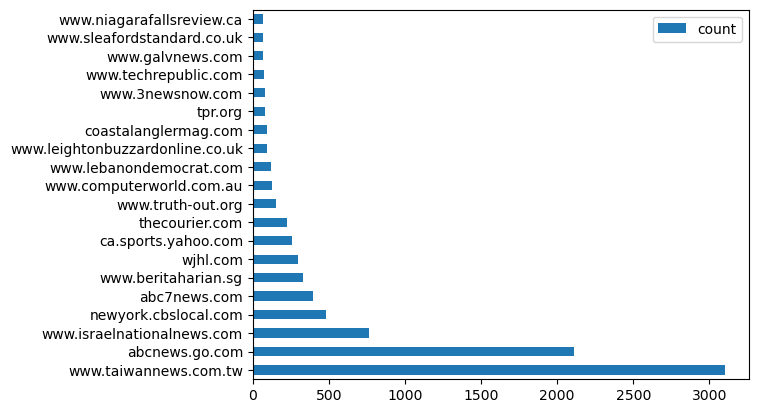

In [103]:
ds_explore.sort_values('count', ascending=False).head(20).plot(kind='barh')

In [7]:
def preprocess(text):
  text = text.lower()
  text = text.replace('\n', ' ').replace(';', '; ').replace('.!?', '_PUNCT_')
  tokens = [token.text for token in nlp(text)]
  return tokens

In [8]:
ds_small_tokenized = ds_small.map(lambda batch: {'tokens': [preprocess(text) for text in batch['text']]}, batched = True)
ds_small_tokenized

Dataset({
    features: ['title', 'text', 'domain', 'tokens'],
    num_rows: 10000
})

In [9]:
corpus = [token for row in ds_small_tokenized['tokens'] for token in row]
len(corpus)

4196480

In [10]:
token_freq = Counter(corpus)
total_token_count = sum(token_freq.values())
token_freq_prob = {token: count / total_token_count for token, count in token_freq.items()}

### Sumbsampling

In [11]:
COMMON_TOKENS_THRESHOLD = 1e-5

def subsampling_prob(token):
  return ((token_freq_prob[token] - COMMON_TOKENS_THRESHOLD) / token_freq_prob[token]) - np.sqrt(COMMON_TOKENS_THRESHOLD / token_freq_prob[token])

keep_prob = {token: subsampling_prob(token) for token in token_freq_prob}

# Function to subsample a text
def subsample_text(text_tokens, keep_prob):
    return [token for token in text_tokens if random.random() > keep_prob[token]]

# Apply subsampling to the entire corpus
ds_small_subsampled = ds_small_tokenized.map(lambda batch: {'tokens_sub': [subsample_text(tokens, keep_prob) for tokens in batch['tokens']]}, batched = True)
ds_small_subsampled = ds_small_subsampled.select_columns('tokens_sub')
ds_small_subsampled

Dataset({
    features: ['tokens_sub'],
    num_rows: 10000
})

In [12]:
# Print the original and subsampled corpus for comparison
print("Original corpus:", len([token for row in ds_small_tokenized['tokens'] for token in row]))
print("Original vocab length:", len(list(set([token for row in ds_small_tokenized['tokens'] for token in row]))))
print("Subsampled corpus:", len([token for row in ds_small_subsampled['tokens_sub'] for token in row]))
print("Subsampled vocab length:", len(list(set([token for row in ds_small_subsampled['tokens_sub'] for token in row]))))

Original corpus: 4196480
Original vocab length: 78995
Subsampled corpus: 1274226
Subsampled vocab length: 78995


### Word2Vec

In [13]:
# Vocabulary
vocab = list(set([token for row in ds_small_subsampled['tokens_sub'] for token in row]))

In [14]:
# Id to token dictionary
id2tok = dict(enumerate(vocab))
print(list(id2tok.items())[:4])

# Token to id dictionary
tok2id = {token: i for (i, token) in id2tok.items()}
print(list(tok2id.items())[:4])

[(0, 'evokes'), (1, 'blueberries'), (2, 'repellant'), (3, '11:56')]
[('evokes', 0), ('blueberries', 1), ('repellant', 2), ('11:56', 3)]


In [15]:
'''
row['tokens] = "a b c d"
WINDOW_WIDTH = 2

i = 0 | j = -2 -> i + j < 0, i + j < 4, j != 0 x
i = 0 | j = -1 -> i + j < 0, i + j < 4, j != 0 x
i = 0 | j = 0 -> i + j = 0, i + j < 4, j = 0 x
i = 0 | j = 1 -> i + j > 0, i + j < 4, j != 0 o --> i + j = 1
i = 0 | j = 2 -> i + j > 0, i + j < 4, j != 0 o --> i + j = 2
out = [(0, 1), (0, 2)]

i = 1 | j = -2 -> i + j < 0, i + j < 4, j != 0 x
i = 1 | j = -1 -> i + j = 0, i + j < 4, j != 0 o --> i + j = 0
i = 1 | j = 0 -> i + j > 0, i + j < 4, j = 0 x
i = 1 | j = 1 -> i + j > 0, i + j < 4, j != 0 o --> i + j = 2
i = 1 | j = 2 -> i + j > 0, i + j < 4, j != 0 o --> i + j = 3
out = [(1, 0), (1, 2), (1, 3)]

i = 2 | j = -2 -> i + j = 0, i + j < 4, j != 0 o --> i + j = 0
i = 2 | j = -1 -> i + j > 0, i + j < 4, j != 0 o --> i + j = 1
i = 2 | j = 0 -> i + j > 0, i + j < 4, j = 0 x
i = 2 | j = 1 -> i + j > 0, i + j < 4, j != 0 o --> i + j = 3
i = 2 | j = 2 -> i + j > 0, i + j < 4, j != 0 o --> i + j = 4
out = [(2, 0), (2, 1), (2, 3), (2, 4)]

i = 3 | j = -2 -> i + j > 0, i + j < 4, j != 0 o --> i + j = 1
i = 3 | j = -1 -> i + j > 0, i + j < 4, j != 0 o --> i + j = 2
i = 3 | j = 0 -> i + j > 0, i + j < 4, j = 0 x
i = 3 | j = 1 -> i + j > 0, i + j < 4, j != 0 o --> i + j = 4
i = 3 | j = 2 -> i + j > 0, i + j > 4, j != 0 x
out = [(3, 1), (3, 2), (3, 4)]

i = 4 | j = -2 -> i + j > 0, i + j < 4, j != 0 o --> i + j = 2
i = 4 | j = -1 -> i + j > 0, i + j < 4, j != 0 o --> i + j = 3
i = 4 | j = 0 -> i + j > 0, i + j < 4, j = 0 x
i = 4 | j = 1 -> i + j > 0, i + j > 4, j != 0 x
i = 4 | j = 2 -> i + j > 0, i + j > 4, j != 0 x
out = [(4, 2), (4, 3)]

row['moving_window'] = [
  (0, 1), (0, 2),
  (1, 0), (1, 2), (1, 3),
  (2, 0), (2, 1), (2, 3), (2, 4),
  (3, 1), (3, 2), (3, 4),
  (4, 2), (4, 3)
]
'''

'\nrow[\'tokens] = "a b c d"\nWINDOW_WIDTH = 2\n\ni = 0 | j = -2 -> i + j < 0, i + j < 4, j != 0 x\ni = 0 | j = -1 -> i + j < 0, i + j < 4, j != 0 x\ni = 0 | j = 0 -> i + j = 0, i + j < 4, j = 0 x\ni = 0 | j = 1 -> i + j > 0, i + j < 4, j != 0 o --> i + j = 1\ni = 0 | j = 2 -> i + j > 0, i + j < 4, j != 0 o --> i + j = 2\nout = [(0, 1), (0, 2)]\n\ni = 1 | j = -2 -> i + j < 0, i + j < 4, j != 0 x\ni = 1 | j = -1 -> i + j = 0, i + j < 4, j != 0 o --> i + j = 0\ni = 1 | j = 0 -> i + j > 0, i + j < 4, j = 0 x\ni = 1 | j = 1 -> i + j > 0, i + j < 4, j != 0 o --> i + j = 2\ni = 1 | j = 2 -> i + j > 0, i + j < 4, j != 0 o --> i + j = 3\nout = [(1, 0), (1, 2), (1, 3)]\n\ni = 2 | j = -2 -> i + j = 0, i + j < 4, j != 0 o --> i + j = 0\ni = 2 | j = -1 -> i + j > 0, i + j < 4, j != 0 o --> i + j = 1\ni = 2 | j = 0 -> i + j > 0, i + j < 4, j = 0 x\ni = 2 | j = 1 -> i + j > 0, i + j < 4, j != 0 o --> i + j = 3\ni = 2 | j = 2 -> i + j > 0, i + j < 4, j != 0 o --> i + j = 4\nout = [(2, 0), (2, 1), (2,

In [16]:
# Skip-grams windows
WINDOW_WIDTH = 5

def windowizer(tokens, wsize = WINDOW_WIDTH):
  out = []
  for i, wd in enumerate(tokens):
    target = tok2id[wd]
    window = [
      i + j for j in range(-wsize, wsize + 1, 1) if (i + j >= 0) & (i + j < len(tokens)) & (j != 0)
    ]
    out += [(target, tok2id[tokens[w]]) for w in window]
  return out

In [17]:
ds_small_subsampled = ds_small_subsampled.map(lambda batch: {'window': [windowizer(tokens) for tokens in batch['tokens_sub']]}, batched = True)
ds_small_subsampled

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset({
    features: ['tokens_sub', 'window'],
    num_rows: 10000
})

In [18]:
class Word2VecDataset(Dataset):
  def __init__(self, dataset, vocab_size):
    self.vocabsize = vocab_size
    self.dataset = dataset
    self.data = [pair for row in dataset['window'] for pair in row]

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

In [19]:
ds_final = Word2VecDataset(
    ds_small_subsampled,
    vocab_size = len(vocab)
)

ds_final

In [20]:
BATCH_SIZE = 100

dataloader = DataLoader(
    ds_final,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 0,
    pin_memory = True
)

In [21]:
len(dataloader)

124440

In [22]:
EMBED_DIM = 100

class Word2Vec(nn.Module):
  def __init__(self, vocab_size = len(vocab), embedding_size = EMBED_DIM):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_size)
    self.expand = nn.Linear(embedding_size, vocab_size, bias=False)

  def forward(self, input):
    target_embedding = self.embedding(input)
    logits = self.expand(target_embedding)
    return logits

In [23]:
model = Word2Vec()
model

Word2Vec(
  (embedding): Embedding(78995, 100)
  (expand): Linear(in_features=100, out_features=78995, bias=False)
)

In [24]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')
device

device(type='cuda', index=0)

In [25]:
torch.cuda.get_device_name(device)

'NVIDIA GeForce MX550'

In [26]:
model.to(device)

Word2Vec(
  (embedding): Embedding(78995, 100)
  (expand): Linear(in_features=100, out_features=78995, bias=False)
)

In [27]:
EPOCHS = 10
LEARNING_RATE = 5e-4
PATH = 'C:/Users/cinthia.nagahama.VERT/Documents/NLP/cc_news/models/'
accumulation_steps = 4  # Accumulate gradients over 4 batches

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE)

def train(model, data, running_loss, epochs = 10):
  pbar = tqdm(range(epochs * len(data)))
  
  for epoch in range(epochs):
    # print(f"### {epoch} ###")
    epoch_loss = 0

    for sample_num, (target, context) in enumerate(data):
      # print(sample_num)
      target = target.to(device)
      context = context.to(device)

      optimizer.zero_grad()
      logits = model(input=context)
      loss = loss_fn(logits, target)

      if not sample_num % 10000:
          pbar.set_description(f'loss[{sample_num}] = {loss.item()}')


      epoch_loss += loss.item()
      loss.backward()
      optimizer.step()  # Update weights after accumulation_steps batches
      pbar.update(1)

    epoch_loss /= len(dataloader)
    running_loss.append(epoch_loss)
    torch.save({
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': loss
    }, PATH + f"model_{epoch}.pt")

  pbar.close()


In [27]:
# running_loss = []

# train(model, dataloader, running_loss, EPOCHS)

# torch.save(model.state_dict(), f'{PATH}model.pt')

loss[120000] = 8.973429679870605: 100%|██████████| 1244400/1244400 [11:06:36<00:00, 31.11it/s]  


In [28]:
# with open(f'{PATH}loss.csv', mode = 'w') as f:
#     f.write("epoch,loss\n")
#     for epoch, loss in enumerate(running_loss):
#         f.write(f"{epoch},{loss}\n")

## Testing

In [29]:
# loading model
model = Word2Vec()
model.load_state_dict(torch.load(f'{PATH}model.pt'))
model.eval()

C:\Users\cinthia.nagahama.VERT\AppData\Local\Temp\ipykernel_26568\1328802782.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{PATH}mod

Word2Vec(
  (embedding): Embedding(78995, 100)
  (expand): Linear(in_features=100, out_features=78995, bias=False)
)

In [30]:
def get_word_embedding(word):
    word_idx = tok2id[word]
    word_embedding = model.embedding.weight[word_idx].detach().numpy()
    return word_embedding

# Example: Get embedding for the word 'there'
embedding = get_word_embedding('there')
print(embedding)

[ 2.75577009e-01  2.29251280e-01  1.22287735e-01 -8.15154463e-02
  2.24760771e-02 -2.45890141e-01  2.46456236e-01  8.15892443e-02
 -9.68852863e-02 -3.55482489e-01 -3.08832210e-02  1.32267047e-02
 -1.62055820e-01  3.47239524e-02 -2.33100772e-01 -1.72088876e-01
 -5.37079237e-02  1.81452319e-01 -1.41386151e-01  1.09844364e-01
  2.42354780e-01 -8.21781829e-02 -6.85782284e-02 -6.23932257e-02
  2.83948388e-02 -7.95573518e-02 -3.96649748e-01 -1.50710240e-01
  1.30201846e-01  1.50595516e-01  3.33870132e-03 -6.11189306e-02
 -2.59046137e-01 -1.06597580e-02 -1.99615315e-01  2.20075428e-01
 -2.08457276e-01  4.51732218e-01  4.61544469e-03  2.48095810e-01
  2.69983649e-01  3.71617004e-02  1.04021363e-01  3.29640098e-02
  2.90426449e-03 -2.28146464e-01  1.20304981e-02  1.57373801e-01
  1.58012971e-01  3.04575086e-01  3.76987100e-01  3.07926685e-01
 -7.35496134e-02 -1.71059191e-01 -1.35996819e-01  2.48627644e-02
  6.82391524e-02 -3.03550772e-02  1.89985484e-01  3.21727812e-01
  1.22312598e-01  5.12436

In [31]:
def find_similar_words(word, top_n=5):
    word_embedding = get_word_embedding(word)
    similarities = {}
    for other_word in vocab:
        if other_word != word:
            other_embedding = get_word_embedding(other_word)
            similarity = np.dot(word_embedding, other_embedding) / (np.linalg.norm(word_embedding) * np.linalg.norm(other_embedding))
            similarities[other_word] = similarity
    return sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:top_n]

# Example: Find words similar to 'there'
similar_words = find_similar_words('there')
print(similar_words)

[('it', 0.7516171), ('what', 0.7206754), ('you', 0.71182114), ('they', 0.7015998), ('like', 0.69066846)]


In [32]:
similar_words = find_similar_words('ballet')
print(similar_words)

[('dancers', 0.81432307), ('artistic', 0.75266457), ('dance', 0.74026996), ('nutcracker', 0.7397715), ('soloist', 0.73797643)]


In [33]:
similar_words = find_similar_words('house')
print(similar_words)

[('speaker', 0.71480584), ('white', 0.6795902), ('senate', 0.65823054), ('ryan', 0.6533851), ('aides', 0.64873344)]


## Classifying News

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [68]:
# loading model
model = Word2Vec()
model.load_state_dict(torch.load(f'{PATH}model.pt'))
model.eval()

C:\Users\cinthia.nagahama.VERT\AppData\Local\Temp\ipykernel_592\1328802782.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{PATH}model

Word2Vec(
  (embedding): Embedding(78995, 100)
  (expand): Linear(in_features=100, out_features=78995, bias=False)
)

In [69]:
def get_average_embedding(tokens, tok2id, embeddings, embedding_dim=100):
    word_embeddings = [embeddings[tok2id[word]] for word in tokens if word in tok2id]
    if len(word_embeddings) > 0:
        return np.mean(word_embeddings, axis=0)
    else:
        return np.zeros(embedding_dim)

In [70]:
ds_small_embeddings = ds_small_tokenized.map(lambda row: {'embeddings': [get_average_embedding(tokens, tok2id, model.embedding.weight.detach().numpy()) for tokens in row['tokens']]}, batched = True)
ds_small_embeddings

Dataset({
    features: ['title', 'text', 'domain', 'tokens', 'embeddings'],
    num_rows: 10000
})

In [71]:
X_train, X_test, y_train, y_test = train_test_split(ds_small_embeddings['embeddings'], ds_small_embeddings['domain'], test_size=0.2, random_state=42)

In [72]:
# Train a logistic regression classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression()

In [75]:
# Evaluate the model
y_pred = classifier.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred, ))
print('Precision:', precision_score(y_test, y_pred, average='macro'))
print('Recall:', recall_score(y_test, y_pred, average='macro'))
print('F1 score:', f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.4245
Precision: 0.05599214783822344
Recall: 0.050875281583712635
F1 score: 0.04859331782355211


c:\Users\cinthia.nagahama.VERT\AppData\Local\miniconda3\envs\venv_ccnews\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [76]:
print(classification_report(y_test, y_pred))

                                       precision    recall  f1-score   support

                         abc7news.com       0.00      0.00      0.00        81
                       abcnews.go.com       0.36      0.28      0.32       443
                       banglalive.com       0.00      0.00      0.00         9
                 baycommunitynews.com       0.00      0.00      0.00         1
                  ca.sports.yahoo.com       0.00      0.00      0.00        50
                 coastalanglermag.com       0.00      0.00      0.00        15
              delawarebusinessnow.com       0.00      0.00      0.00         7
                      flowingdata.com       0.00      0.00      0.00         1
               georgiatech.rivals.com       0.00      0.00      0.00         2
                hardware.slashdot.org       0.00      0.00      0.00         7
                           hcnews.com       0.00      0.00      0.00        14
                        info.umkc.edu       0.00   

c:\Users\cinthia.nagahama.VERT\AppData\Local\miniconda3\envs\venv_ccnews\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cinthia.nagahama.VERT\AppData\Local\miniconda3\envs\venv_ccnews\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\cinthia.nagahama.VERT\AppData\Local\miniconda3\envs\venv_ccnews\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param